<a href="https://colab.research.google.com/github/asafe-eduardo/colab/blob/master/rnn_from_scratch/lstm_gru_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORTS

In [0]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

### PREPROCESSING ###

In [0]:
def normalize_values(data):
  scaler = sklearn.preprocessing.MinMaxScaler()
  return scaler.fit_transform(data.values.reshape(-1,1))

In [0]:
dataframe = pd.read_csv('RELIANCE.NS.csv', index_col = 0)
df_stock = dataframe.copy()
df_stock = df_stock.dropna()
df_stock = df_stock[['Open', 'High', 'Low', 'Close']]

In [0]:
df_stock['Open'] = normalize_values(df_stock['Open'])
df_stock['High'] = normalize_values(df_stock['High'])
df_stock['Low'] = normalize_values(df_stock['Low'])
df_stock['Close'] = normalize_values(df_stock['Close'])

### LOAD DATA ###

In [0]:
valid_set_size_percentage = 20
test_set_size_percentage = 20
seq_len = 20

def load_data(stock, seq_len):
  data_raw = stock.values
  data = []
  for index in range(len(data_raw) - seq_len):
    data.append(data_raw[index: index+seq_len])
  data = np.array(data)
  
  valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]))
  test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
  train_set_size = data.shape[0] - (valid_set_size + test_set_size)
  
  x_train = data[:train_set_size, :-1, :]
  y_train = data[:train_set_size, -1, :]
  x_valid = data[train_set_size:train_set_size+valid_set_size,:-1, :]
  y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
  x_test = data[train_set_size+valid_set_size:, :-1, :]
  y_test = data[train_set_size+valid_set_size:,-1,:]
  return [x_train, y_train, x_valid,y_valid,x_test,y_test]

### splitting

In [0]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock, seq_len)

### MODEL ###

### initializing variables

In [0]:
n_steps = seq_len-1
n_inputs = 4
n_neurons = 200
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

In [0]:
index_in_epoch = 0;
perm_array = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
  global index_in_epoch, x_train, perm_array
  start = index_in_epoch
  index_in_epoch += batch_size
  if index_in_epoch > x_train.shape[0]:
    np.random.shuffle(perm_array)
    start = 0
    index_in_epoch = batch_size
  end = index_in_epoch
  return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

### BUILD MODEL

In [0]:
# GRU
layers = [tf.keras.layers.GRUCell(units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

multi_layer_cell = tf.keras.layers.StackedRNNCells(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:, n_steps-1, :] 

W0715 20:08:43.447061 139659395258240 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0715 20:08:43.459773 139659395258240 deprecation.py:323] From <ipython-input-33-04b8e2ce65fc>:5: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0715 20:08:43.743323 139659395258240 deprecation.py:323] From <ipython-input-33-04b8e2ce65fc>:11: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


Tensor("rnn/transpose_1:0", shape=(?, 19, 200), dtype=float32)


In [0]:
loss = tf.math.reduce_mean(tf.math.square(outputs - y)) # MSE

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # GRADIENT
training_op = optimizer.minimize(loss)

W0715 20:08:44.286855 139659395258240 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  for iteration in range(int(n_epochs*train_set_size/batch_size)):
    x_batch, y_batch = get_next_batch(batch_size)
    sess.run(training_op, feed_dict={X: x_batch, y:y_batch})
    
    if iteration % int(5*train_set_size/batch_size) == 0:
      mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
      mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
      print('%d epochs: MSE train/valid = %.6f/%.6f'%(
          int(np.round(iteration*batch_size/train_set_size)), mse_train, mse_valid))
      
  y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0 epochs: MSE train/valid = 0.013849/0.051102
5 epochs: MSE train/valid = 0.000095/0.000208
10 epochs: MSE train/valid = 0.000074/0.000088
15 epochs: MSE train/valid = 0.000053/0.000050
20 epochs: MSE train/valid = 0.000121/0.000262
25 epochs: MSE train/valid = 0.000082/0.000174
30 epochs: MSE train/valid = 0.000052/0.000055
35 epochs: MSE train/valid = 0.000046/0.000042
40 epochs: MSE train/valid = 0.000050/0.000057
45 epochs: MSE train/valid = 0.000063/0.000076
50 epochs: MSE train/valid = 0.000045/0.000033
55 epochs: MSE train/valid = 0.000066/0.000107
60 epochs: MSE train/valid = 0.000046/0.000055
65 epochs: MSE train/valid = 0.000075/0.000131
70 epochs: MSE train/valid = 0.000050/0.000076
75 epochs: MSE train/valid = 0.000043/0.000050
80 epochs: MSE train/valid = 0.000039/0.000027
85 epochs: MSE train/valid = 0.000040/0.000027
90 epochs: MSE train/valid = 0.000038/0.000034
95 epochs: MSE train/valid = 0.000043/0.000050
100 epochs: MSE train/valid = 0.000047/0.000079


### PLOT

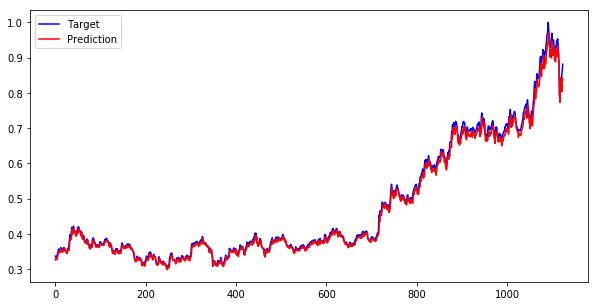

In [0]:
results = pd.DataFrame({'true_y':y_test[:, 3], 'y_pred':y_test_pred[:, 3]})
plt.figure(figsize=(10,5))
plt.plot(results['true_y'], color='blue', label='Target')
plt.plot(results['y_pred'], color='red', label='Prediction')
plt.legend()
plt.show()